# Explore here

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime



In [4]:
# Apertura de datasets

appearence = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/appearance_agrupado.csv")
#club_games = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/club_games.csv")
#clubs = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/clubs.csv")
#competitions = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/competitions.csv")
#game_events = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/game_events.csv")
#game_lineups = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/game_lineups.csv")
transfers = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/transfers.csv")
players = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/players.csv")
#games = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/games.csv")
player_valuations = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/player_valuations.csv")

#  Datasets en un diccionario para organizarlos
#datasets = {"Appearence": appearence, "Club Games": club_games, "Clubs": clubs, "Competitions": competitions,
 #           "Game events":game_events, "Game Lineups":game_lineups, "Transfers":transfers, "Players":players,
  #          "Games":games, "Player Valuations":player_valuations}

ds_players_info= {"Appearence": appearence, "Players":players, "Player Valuations":player_valuations}

for name, dataset in ds_players_info.items():
    print(f"El shape de {name}: {dataset.shape}")


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/appearance_agrupado.csv'

In [3]:
for name, dataset in ds_players_info.items():
    print(f"Las columnas de {name}: {dataset.columns}")

Las columnas de Appearence: Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played'],
      dtype='object')
Las columnas de Players: Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='object')
Las columnas de Player Valuations: Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')


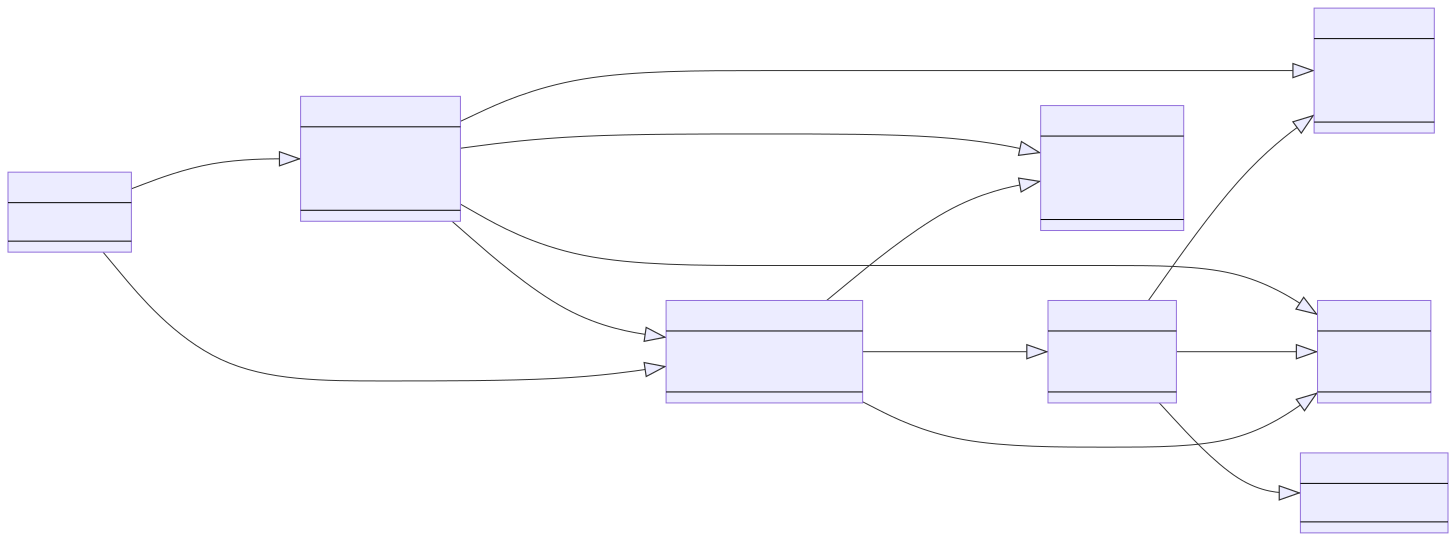

In [23]:
from IPython.display import SVG, display

display(SVG(filename="/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/diagram.svg"))

### Dataset filtrados por columnas relevantes:

In [4]:
appearence_filtered=appearence.drop(["appearance_id", "player_current_club_id"], axis = 1)
player_valuations_filtered=player_valuations.drop(["current_club_id", "player_club_domestic_competition_id"], axis = 1)
players_filtered=players.drop(["first_name", "last_name", "last_season", "current_club_id", "player_code", "contract_expiration_date","agent_name","image_url","url", "current_club_domestic_competition_id","current_club_name","market_value_in_eur"], axis = 1)

Agregamos la edad de los jugadores en cada partido:

In [5]:
# Convert 'date' column to datetime
appearence_filtered['date'] = pd.to_datetime(appearence_filtered['date'])

# Ensure 'date_of_birth' is in datetime format
players_filtered['date_of_birth'] = pd.to_datetime(players_filtered['date_of_birth'])

players_birth=players_filtered[["player_id",'date_of_birth']]
players_birth.head()

# Hacemos el merge:
appearence_filtered = pd.merge(appearence_filtered, players_birth, on=['player_id'], how='left')

# Agregamos edad:
appearence_filtered["age"]=appearence_filtered["date"]-appearence_filtered['date_of_birth']
appearence_filtered["age"] = (appearence_filtered["age"].dt.days // 365.25)

appearence_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697243 entries, 0 to 697242
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   game_id         697243 non-null  int64         
 1   player_id       697243 non-null  int64         
 2   player_club_id  697243 non-null  int64         
 3   date            697243 non-null  datetime64[ns]
 4   player_name     697243 non-null  object        
 5   competition_id  697243 non-null  object        
 6   yellow_cards    697243 non-null  int64         
 7   red_cards       697243 non-null  int64         
 8   goals           697243 non-null  int64         
 9   assists         697242 non-null  float64       
 10  minutes_played  697242 non-null  float64       
 11  date_of_birth   696492 non-null  datetime64[ns]
 12  age             696492 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(6), object(2)
memory usage: 69.2+ MB


In [8]:
appearence_filtered.isnull().sum().sort_values(ascending=False)

date_of_birth     751
age               751
assists             1
minutes_played      1
game_id             0
player_name         0
date                0
player_club_id      0
player_id           0
goals               0
red_cards           0
yellow_cards        0
competition_id      0
dtype: int64

In [9]:
appearence_filtered = appearence_filtered.dropna()
appearence_filtered.shape

(696491, 13)

Acá esta hecho el groupby por jugador y por año:

In [13]:
# 1. Convertir la columna 'date' al formato datetime (si no lo está ya)
appearence_filtered['date'] = pd.to_datetime(appearence_filtered['date'])

# 2. Crear una nueva columna que contenga el año del partido
appearence_filtered['year'] = appearence_filtered['date'].dt.year

# 3. Agrupar por 'player_id' y 'year', y calcular agregados para cada columna relevante
gb_app = appearence_filtered.groupby(['player_id', 'year', "competition_id", "player_club_id","player_name"]).agg({
    'game_id': 'count',               # Número de partidos jugados
    'yellow_cards': 'mean',            # Total de tarjetas amarillas
    'red_cards': 'mean',               # Total de tarjetas rojas
    'goals': 'mean',                   # Total de goles
    'assists': 'mean',                 # Total de asistencias
    'minutes_played': 'mean',           # Total de minutos jugados
    "age" : "mean"
}).reset_index()

# 4. Renombrar la columna 'game_id' a algo más significativo (opcional)
gb_app = gb_app.rename(columns={'game_id': 'matches_played'})

# 5. Ver el resultado
print(gb_app)

       player_id  year competition_id  player_club_id      player_name  \
0             10  2012             EL             398   Miroslav Klose   
1             10  2012            ELQ             398   Miroslav Klose   
2             10  2012            IT1             398   Miroslav Klose   
3             10  2013            CIT             398   Miroslav Klose   
4             10  2013             EL             398   Miroslav Klose   
...          ...   ...            ...             ...              ...   
89401     550027  2017           UKRP            6993     Eriks Santos   
89402     550323  2017           UKRP           23611    Nazar Yedynak   
89403     552445  2015           POCP            2425      Bruno Sousa   
89404     573775  2017            CDR            3709        Hugo Duro   
89405     581749  2017           UKRP           49634  Viktor Barabash   

       matches_played  yellow_cards  red_cards     goals   assists  \
0                   2      0.000000      

Groupby Player_valuation

In [14]:
# 1. Convertir la columna 'date' al formato datetime (si no lo está ya)
player_valuations_filtered['date'] = pd.to_datetime(player_valuations_filtered['date'])

# 2. Crear una nueva columna que contenga el año del partido
player_valuations_filtered['year'] = player_valuations_filtered['date'].dt.year

# 3. Agrupar por 'player_id' y 'year', y calcular agregados para cada columna relevante
gb_player_val = player_valuations_filtered.groupby(['player_id', 'year']).agg({
    "market_value_in_eur":"mean"
}).reset_index()

# 4. Ver el resultado
print(gb_player_val)

        player_id  year  market_value_in_eur
0              10  2004            7000000.0
1              10  2005           12000000.0
2              10  2006           25000000.0
3              10  2007           23000000.0
4              10  2008           20000000.0
...           ...   ...                  ...
249886    1294052  2024             150000.0
249887    1296876  2024             500000.0
249888    1302421  2024             100000.0
249889    1306131  2024             100000.0
249890    1306851  2024              50000.0

[249891 rows x 3 columns]


Hacemos el merge (hay algunas valuaciones que se pierden)

In [15]:
# Hacemos el merge:
app_plval_merged = pd.merge(gb_app, gb_player_val, on=['player_id', 'year'], how='inner')
print(app_plval_merged.shape)
app_plval_merged

(85732, 13)


,player_id,year,competition_id,player_club_id,player_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur
0,10,2012,EL,398,Miroslav Klose,2,0.000000,0.0,0.000000,0.000000,52.000000,34.000000,6000000.0
1,10,2012,ELQ,398,Miroslav Klose,1,1.000000,0.0,1.000000,0.000000,83.000000,34.000000,6000000.0
2,10,2012,IT1,398,Miroslav Klose,17,0.294118,0.0,0.588235,0.058824,76.235294,34.000000,6000000.0
3,10,2013,CIT,398,Miroslav Klose,2,0.500000,0.0,0.000000,0.000000,80.000000,34.000000,3000000.0
4,10,2013,EL,398,Miroslav Klose,3,0.333333,0.0,0.000000,0.000000,22.333333,34.333333,3000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85727,529596,2017,GRP,6418,Alexandros Parras,2,0.000000,0.0,0.000000,0.000000,90.000000,19.000000,75000.0
85728,529731,2017,PO1,1465,Duarte Valente,3,0.333333,0.0,0.000000,0.333333,55.000000,17.000000,200000.0
85729,532444,2017,GRP,2672,Fotis Ioannidis,1,0.000000,0.0,0.000000,0.000000,21.000000,17.000000,50000.0
85730,534438,2017,DK1,22110,Matheus Leiria,5,0.000000,0.0,0.000000,0.000000,70.400000,22.000000,100000.0


Otros tipos de merge:

In [16]:
# Hacemos el merge:
app_plval_merged2 = pd.merge(gb_app, gb_player_val, on=['player_id', 'year'], how='right')
print(app_plval_merged2.shape)

app_plval_merged3 = pd.merge(gb_app, gb_player_val, on=['player_id', 'year'], how='left')
print(app_plval_merged3.shape)

app_plval_merged4 = pd.merge(gb_app, gb_player_val, on=['player_id', 'year'], how='outer')
print(app_plval_merged4.shape)

(293892, 13)
(89406, 13)
(297566, 13)


Aquí el merge con la información de los jugadores (posible df final)

In [22]:
df = pd.merge(app_plval_merged, players_filtered, on=['player_id'], how='inner')
df = df.drop(["name"], axis = 1)
print(df.shape)
df.info()

(85732, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85732 entries, 0 to 85731
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    85732 non-null  int64         
 1   year                         85732 non-null  int32         
 2   competition_id               85732 non-null  object        
 3   player_club_id               85732 non-null  int64         
 4   player_name                  85732 non-null  object        
 5   matches_played               85732 non-null  int64         
 6   yellow_cards                 85732 non-null  float64       
 7   red_cards                    85732 non-null  float64       
 8   goals                        85732 non-null  float64       
 9   assists                      85732 non-null  float64       
 10  minutes_played               85732 non-null  float64       
 11  age                          

In [24]:
duplicados = df.duplicated()
num_duplicados = duplicados.sum()
print(f"La cantidad de duplicados en nuestro dataset: {num_duplicados}")

La cantidad de duplicados en nuestro dataset: 0


- Contamos con 85732 datos y 22 atributos.
- No tenemos datos duplicados.
- Contamos con algunos valores nulos en las variables "country_of_birth", "city_of_birth", "country_of_citizenship", "sub_position", "foot", "height_in_cm".
- 9 características son numéricas, entre las cuales se encuentra nuestra variable objetivo Outcome que está codificada con el valor 0 para quién no posee diabetes y valor 1 para quién sí lo hace.

In [19]:
messi=df[df['player_id'] == 28003]
messi

,player_id,year,competition_id,player_club_id,player_name,matches_played,yellow_cards,red_cards,goals,assists,...,name,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur
15952,28003,2012,CDR,131,Lionel Messi,1,0.000000,0.0,2.000000,0.000000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15953,28003,2012,CL,131,Lionel Messi,6,0.000000,0.0,0.833333,0.500000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15954,28003,2012,ES1,131,Lionel Messi,17,0.058824,0.0,1.529412,0.352941,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15955,28003,2012,SUC,131,Lionel Messi,2,0.000000,0.0,1.000000,0.000000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15956,28003,2013,CDR,131,Lionel Messi,4,0.250000,0.0,0.500000,0.250000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15957,28003,2013,CL,131,Lionel Messi,8,0.000000,0.0,1.125000,0.000000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15958,28003,2013,ES1,131,Lionel Messi,26,0.000000,0.0,1.076923,0.423077,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15959,28003,2013,SUC,131,Lionel Messi,2,0.000000,0.0,0.000000,0.000000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15960,28003,2014,CDR,131,Lionel Messi,6,0.166667,0.0,0.833333,0.500000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0
15961,28003,2014,CL,131,Lionel Messi,10,0.000000,0.0,1.000000,0.200000,...,Lionel Messi,Argentina,Rosario,Argentina,1987-06-24,Right Winger,Attack,left,170.0,180000000.0


In [43]:
messi_player=players[players['player_id'] == 28003]
messi_player

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
2347,28003,Lionel,Messi,Lionel Messi,2022,583,lionel-messi,Argentina,Rosario,Argentina,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0


In [44]:
messi_pl_val=player_valuations[player_valuations['player_id'] == 28003]
messi_pl_val

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
2248,28003,2004-12-20,3000000,583,FR1
4728,28003,2005-12-28,5000000,583,FR1
4959,28003,2006-01-20,15000000,583,FR1
9674,28003,2007-07-26,40000000,583,FR1
11042,28003,2007-09-12,60000000,583,FR1
14290,28003,2008-02-04,55000000,583,FR1
17826,28003,2008-07-10,55000000,583,FR1
23698,28003,2009-01-26,55000000,583,FR1
25586,28003,2009-04-28,60000000,583,FR1
28672,28003,2009-07-22,70000000,583,FR1
